In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
#import os

#import string

%matplotlib inline

In [37]:
# Read in the saved files
directory = 'Binned_results/'

files = glob.glob('Binned_results/*.csv')
all_frames_lst = []

for file in files:
    frame = pd.read_csv(file)
    all_frames_lst.append(frame)
    
master = pd.concat(all_frames_lst)

In [38]:
master.Animal.unique()

array(['2CW100', '2CW305', '2CW306', '2CW308', '2CW312', '2CW317',
       '2CW318', 'LB06', 'LB11', 'LB15', 'LB21', 'LB2', 'Or114', 'Or128',
       'Or130', 'Z1Pi229', 'Z1Pi230'], dtype=object)

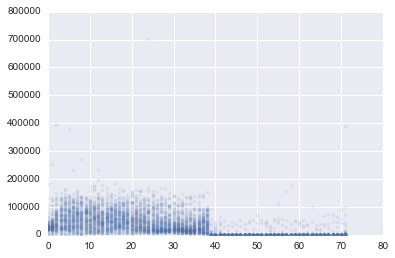

In [39]:
plt.plot(master.Period, master.Activity, '.', alpha=0.1)

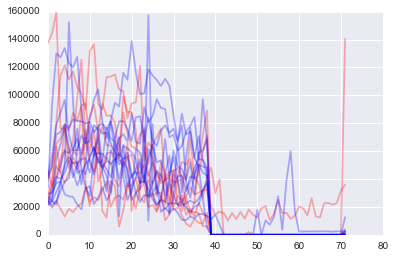

In [46]:
# Get average activity for each animal
mean_fr = master.groupby(['Animal','Period']).mean()['Activity']
mean_fr = mean_fr.reset_index()

# Plot
for animal in mean_fr.Animal.unique():
    animal_fr = mean_fr[mean_fr.Animal == animal]
    if '2CW' in animal: # mutant
        plt.plot(animal_fr.Period, animal_fr.Activity, alpha=0.3, color='red')
    else: # wild-type
        plt.plot(animal_fr.Period, animal_fr.Activity, alpha=0.3, color='blue')
        

In [41]:
mean_fr.Animal.unique()

array(['2CW100', '2CW305', '2CW306', '2CW308', '2CW312', '2CW317',
       '2CW318', 'LB06', 'LB11', 'LB15', 'LB2', 'LB21', 'Or114', 'Or128',
       'Or130', 'Z1Pi229', 'Z1Pi230'], dtype=object)

In [44]:
'Pi' in animal

True